# Lasso regression on data smoothed with Gaussian (n = 10)

In [7]:
library(tidyverse)

#install.packages('scales')
library(scales)

#install.packages("slider")
library(slider)

library(glmnet)

In [8]:
sum_control_ATAC_bin_rm = read.csv("sum_control_ATAC_bin_rm.csv")
sum_control_ATAC = read.csv("sum_control_ATAC.csv")

ATAC_val <- sum_control_ATAC_bin_rm %>% select(ATAC_val)

sum_control_ATAC_bin_rm = sum_control_ATAC_bin_rm %>% select(-ATAC_val)

In [9]:
head(sum_control_ATAC_bin_rm)

X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700
8.699646e-07,3.479859e-06,2.609894e-06,0.000000e+00,8.699646e-07,8.699646e-07,1.739929e-06,1.739929e-06,0.000000e+00,2.609894e-06,...,0,0,0,0,0,0,0,0,0,0.000000e+00
8.313727e-07,8.313727e-07,0.000000e+00,8.313727e-07,1.662745e-06,8.313727e-07,8.313727e-07,5.819609e-06,3.325491e-06,3.325491e-06,...,0,0,0,0,0,0,0,0,0,0.000000e+00
8.705774e-07,1.741155e-06,8.705774e-07,8.705774e-07,0.000000e+00,0.000000e+00,2.611732e-06,3.482309e-06,0.000000e+00,8.705774e-07,...,0,0,0,0,0,0,0,0,0,8.705774e-07
0.000000e+00,1.700685e-06,0.000000e+00,8.503423e-07,8.503423e-07,1.700685e-06,8.503423e-07,0.000000e+00,8.503423e-07,8.503423e-07,...,0,0,0,0,0,0,0,0,0,0.000000e+00
0.000000e+00,9.416577e-07,0.000000e+00,0.000000e+00,9.416577e-07,0.000000e+00,9.416577e-07,0.000000e+00,2.824973e-06,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0.000000e+00
0.000000e+00,0.000000e+00,0.000000e+00,4.221123e-06,1.688449e-06,1.688449e-06,8.442245e-07,0.000000e+00,2.532674e-06,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0.000000e+00


In [10]:
#################################################################
gaussian_smoothing <- function(bin, sd_percentage = 25) {
  bin_size <- length(bin)
  if (bin_size %% 2 == 0) {
    stop("`bin` should have an odd number of elements")
  }

  # Create density for normal distribution
  bin_indices <- seq_len(bin_size)
  sd <- bin_size * (sd_percentage / 100)
  weights <- dnorm(
    bin_indices,
    mean = ceiling(bin_size / 2),
    sd = sd
  )

  # Ensure the weights sum to 1 (they should already, I think)
  weights <- weights / sum(weights)

  # Weighted sum
  sum(bin * weights)
}
#################################################################
bin_size <- 11
signal_size <- 671
sum_control_ATAC_bin_rm_gaussian_mean <- matrix(ncol = 671, nrow = 0)

for (row in 1:nrow(sum_control_ATAC_bin_rm)){
    row_cur <- sum_control_ATAC_bin_rm[row, ]
    row_cur <- as.vector(t(row_cur))
    
    smoothed <- rep(0, ceiling(bin_size / 2))
    for (i in seq_len(signal_size - bin_size)) {
      smoothed <- c(smoothed, gaussian_smoothing(row_cur[i:(i+bin_size-1)]))
    }
    smoothed <- c(smoothed, rep(0, floor(bin_size / 2)))
    sum_control_ATAC_bin_rm_gaussian_mean <- rbind(sum_control_ATAC_bin_rm_gaussian_mean, smoothed)
    }

sum_control_ATAC_bin_rm_gaussian_mean <- as.data.frame(sum_control_ATAC_bin_rm_gaussian_mean, index = FALSE)
colnames(sum_control_ATAC_bin_rm_gaussian_mean) <- colnames(sum_control_ATAC_bin_rm)
rownames(sum_control_ATAC_bin_rm_gaussian_mean) <- NULL

head(sum_control_ATAC_bin_rm_gaussian_mean)

X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700
0,0,0,0,0,0,1.295662e-06,1.315240e-06,1.377055e-06,1.493326e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0
0,0,0,0,0,0,1.898063e-06,2.292049e-06,2.673739e-06,2.929634e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0
0,0,0,0,0,0,1.114137e-06,1.158812e-06,1.143512e-06,1.142800e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0
0,0,0,0,0,0,8.292440e-07,8.302439e-07,8.203466e-07,8.455300e-07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0
0,0,0,0,0,0,6.358502e-07,7.854683e-07,1.037024e-06,1.299074e-06,...,1.429406e-07,1.337957e-07,1.097238e-07,7.883745e-08,4.962914e-08,0,0,0,0,0
0,0,0,0,0,0,1.369131e-06,1.302297e-06,1.181740e-06,1.057154e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0


## Saving the data for other scripts

In [11]:
write.csv(sum_control_ATAC_bin_rm_gaussian_mean, "sum_control_ATAC_bin_rm_gaussian_mean.csv",  row.names = FALSE)

In [6]:
sum_control_ATAC_bin_rm_gaussian_mean <- read.csv("sum_control_ATAC_bin_rm_gaussian_mean.csv")
head(sum_control_ATAC_bin_rm_gaussian_mean)

X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,...,X691,X692,X693,X694,X695,X696,X697,X698,X699,X700
0,0,0,0,0,0,1.295662e-06,1.315240e-06,1.377055e-06,1.493326e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0
0,0,0,0,0,0,1.898063e-06,2.292049e-06,2.673739e-06,2.929634e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0
0,0,0,0,0,0,1.114137e-06,1.158812e-06,1.143512e-06,1.142800e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0
0,0,0,0,0,0,8.292440e-07,8.302439e-07,8.203466e-07,8.455300e-07,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0
0,0,0,0,0,0,6.358502e-07,7.854683e-07,1.037024e-06,1.299074e-06,...,1.429406e-07,1.337957e-07,1.097238e-07,7.883745e-08,4.962914e-08,0,0,0,0,0
0,0,0,0,0,0,1.369131e-06,1.302297e-06,1.181740e-06,1.057154e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0


## Finding the best lambda

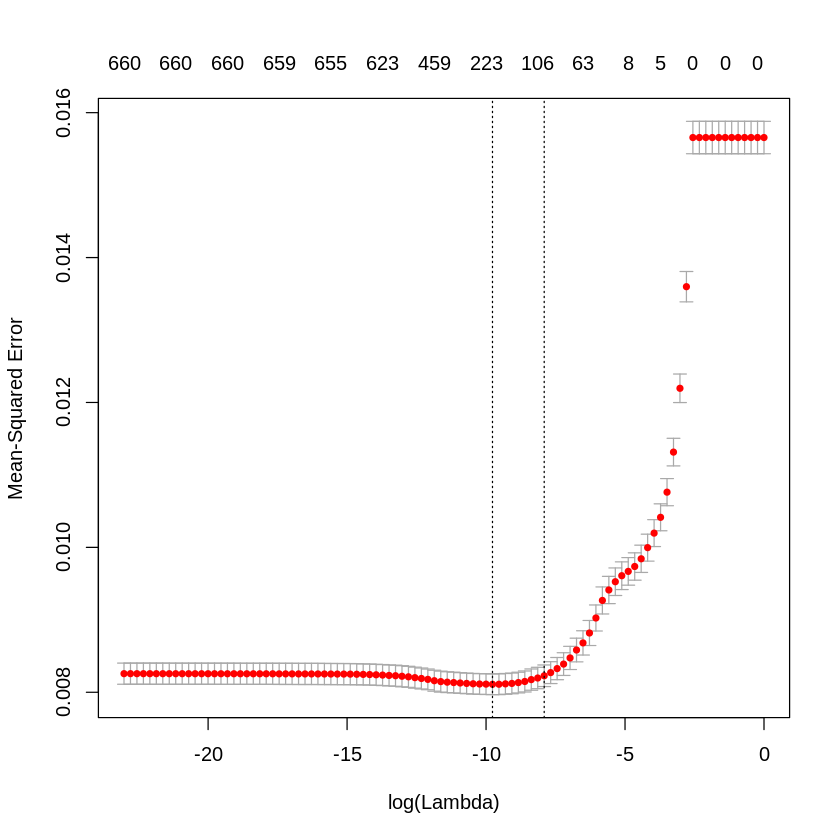

In [7]:
set.seed(0)
#X==predictor
#y==response
#sum_control_ATAC_bin_rm <- sum_control_ATAC  %>% dplyr::select(-bin)

y <- ATAC_val %>% as.matrix()
X <- sum_control_ATAC_bin_rm_gaussian_mean %>% as.matrix()
#head(X)

lambdas_to_try <- 10^seq(-10, 0, length.out = 100)
#standardize = FALSE -- range -12, -3
#standardize = TRUE -- range -10, 0


lasso_smooth_cv <- cv.glmnet(X, y, alpha = 1, lambda = lambdas_to_try,
                      standardize = TRUE, nfolds = 10)

#Plotting the MSE and log(lambda)

plot(lasso_smooth_cv)

In [8]:
lambda_smooth_cv <- lasso_smooth_cv$lambda.min

In [9]:
CV_lasso_smooth<-function(data, nfolds){
    set.seed(0)
    cvfolds <- cut(1:nrow(data), breaks = nfolds, labels = F)
    cvfolds <- sample(cvfolds)
    

    predicted <- rep(NA, nrow(data))
    #data_as_matrix <- data %>% dplyr::select(-ATAC_val) %>% as.matrix() 
    
    y <- ATAC_val %>%  as.matrix()
    X <- sum_control_ATAC_bin_rm_gaussian_mean %>% as.matrix()
    
    for (i in 1:nfolds){
        rows      <- which(cvfolds==i)
        testdata  <- X[rows,]
        traindata <- X[-rows,]
        train_y <- y[-rows,]

        fit       <- glmnet(traindata, train_y, alpha = 1, lambda = lambda_smooth_cv, standardize = TRUE)
        tmp       <- predict(fit, s=lambda_smooth_cv, testdata)
        predicted[rows] <- tmp
    }
    
    rm(tmp)
    observed <- y
    head(observed)
    mean(observed)
    se    <- (observed-predicted)^2
    mse   <- mean(se)
    (rmse <- sqrt(mse))
    
    return(tibble(observed = observed, predicted = predicted))
}

In [10]:
res_lasso_smooth_gaussian_pred <- CV_lasso_smooth(sum_control_ATAC_bin_rm_gaussian_mean, 10)

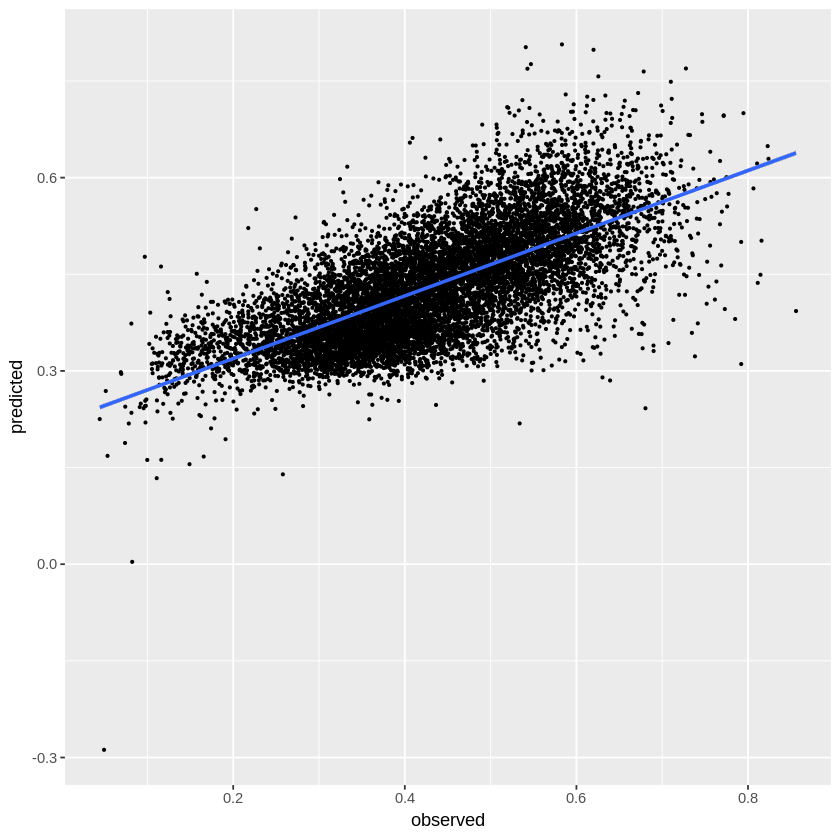

In [11]:
ggplot(res_lasso_smooth_gaussian_pred, aes(x = observed, y = predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [12]:
cor(res_lasso_smooth_gaussian_pred$observed, res_lasso_smooth_gaussian_pred$predicted)

# Standardize = TRUE: ATAC_val 0.6947938

# Standardize = FALSE: ATAC_val 0.6962595

ATAC_val,0.6947938
